In [ ]:
import os
import time
import datetime

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

In [ ]:
!nvidia-smi

In [40]:
df = pd.read_csv ('../genre_Identfier/gameSynopsis_genre.csv')  
df.dropna(inplace=True) #removing anything that has N/A as values
df_subset = df.head(5000) #Can remove this later, there are 18686 rows but just taking 5k from it for testing purpose
synopsis = df_subset.summary.copy()
print(synopsis.count())

5000


/var/folders/4v/wcwl8gtj5cv041_1rjy0fphc0000gn/T/ipykernel_1325/2774666547.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(doc_lengths)


<Axes: ylabel='Density'>

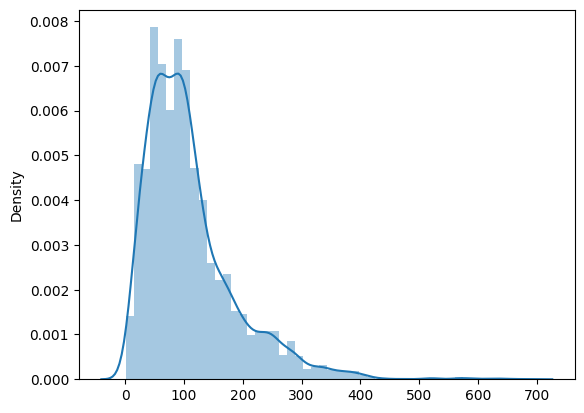

In [41]:
doc_lengths = []

for synop in synopsis:
    tokens = nltk.word_tokenize(synop)
    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)

In [42]:
len(doc_lengths[doc_lengths > 768])/len(doc_lengths)

0.0

In [43]:
np.average(doc_lengths)

109.992

In [44]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium

In [45]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


In [46]:
batch_size = 2

In [48]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

In [49]:
dataset = GPT2Dataset(synopsis, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

4,500 training samples
  500 validation samples


In [51]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [52]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.

if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [53]:
# some parameters I cooked up that work reasonably well

epochs = 2 #for now, I will put this to 2, the previous was 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [54]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [55]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [56]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [57]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  2,250. Loss: 0.6253482103347778.   Elapsed: 0:01:38.
0:  bipartisan-, yet not only for their experience, but for their much experience in the world as an alien planet on Earth has come into light and gone dark. They will continue their quest for peace and order in an increasingly dangerous pursuit against their warlord and his powerful friends. They must defeat their foes in this epic fantasy adventure that includes elements such as battle skills, character customization and the ability to navigate through the world with its vast array of weapons. Their mission is to gather a great army and deliver the largest military base in the world, to unite humanity in their mission to destroy the aliens. With the ability to maneuver within any terrain, players will have a complete control of his/her abilities, and the abilities of the player. For more complete gameplay you can explore the series from the previous installment.
 had his hair upon the new week!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  2,250. Loss: 0.8797956705093384.   Elapsed: 0:03:22.
0:  increasingThe Sims 4: The Sims 4: The Sims Collection is one of the most critically acclaimed and critically acclaimed video games ever released. Each of the game's most famous characters, as wellmores, have their own unique abilities, abilities and skills, but can also take on additional roles, including managing the family, raising sons, and leading a team. With a vast array of Sims, the Sims 4: The Sims Collection delivers alluring and powerful features.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  2,250. Loss: 0.46562910079956055.   Elapsed: 0:04:58.
0: dayTremored delivers new story elements that make it easier to follow the story along with unique endings and a truly exciting action/ combat experience. Each story can be found in a different location, and the action is highly dependent on the player's movements and actions. The original game featured a variety of gameplay elements that were released as downloadable content in a variety of games, including the original game, and the enhanced version of the original version. The inclusion of new features suchaking, biopsies, and more added to the game make it easier to follow the story along. You can find more than 150 more gameplay videos, as well as an updated story, a new storyline and more. With over 35,000+ gameplay videos, you'll have a great experience on the go!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  2,250. Loss: 0.4089544713497162.   Elapsed: 0:06:31.
0:  HangThe latest addition to the Xamarin team is The Ultimate Hitman: Winter's Reward. In the new world of Winter's Reward, a man named Paul is on the brink of his doom, attempting to steal the coveted Winter's Reward. When he discovers a girl, she is trapped in an open house where they discover an undercover agent named Red Hand, who is stalking her.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  2,250. Loss: 1.241949439048767.   Elapsed: 0:08:00.
0:  foodsThe Sims 4 brings the Sims from the past and present into the world of Rivets. Explore diverse and mysterious environments with over 200 new features including, new interactive challenges, new characters, and more.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  2,250. Loss: 0.21480704843997955.   Elapsed: 0:09:28.
0:  trailWhen you jump onto the stage of the critically acclaimed Legend of Zelda: The Wind Waker, you'll travel deep into lush forest, lush dungeons and the surrounding landscapes to find yourself on the moon, which, many, can only be a good thing. Players must master an array of skills in order to explore and colonize a vast world of fantastical landscapes. An epic, dark, and highly interconnected world that also promises to appeal to people who enjoy a Zelda experience. From the outside of the world, players will feel isolated, or even stalked. On top of the world, players will find themselves in the middle. [Nintendo]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  2,250. Loss: 0.7627566456794739.   Elapsed: 0:10:59.
0: intendGet ready for the biggest-than-ever Street Fighter vs. Street Fighter vs. UFC UFC on Wii U. The action is as exciting as ever, but it's also packed with tons of fun. Featuring a revolutionary-defining character that sets him apart from the crowd, and an unbeatable crowd full of fans that don't leave him speechless, the first title that debuted on the PlayStation 3 in 2001 has gone on to make for a massive box office success.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  2,250. Loss: 0.38189035654067993.   Elapsed: 0:12:30.
0:  surroundAn old friend, a little girl and her mother, first time, caught fire with a flaming sword. The girl, who had fallen in love with the girl, had taken sword to escape the flames, and had been sent back to her own childhood by the woman herself. Now, after a long journey, the girl has become entangled in flames. You must find the girl's father, who has set it free before she has a chance. In this story, each time the girl awakes, her father will have something to offer to her. One night, a young girl left her hometown for a long journey to find her father and find her home back in the heart of a small village. A little girl, who had been missing for a long time, was caught in her father's fiery fire. Now, a little girl will grow up to be a girl, or she will die alone as she struggles in her search for her home. This tale of love and death


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  2,250. Loss: 0.37280744314193726.   Elapsed: 0:14:08.
0:  reflexThe ultimate sports simulator fromgamer.com.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  2,250. Loss: 1.004300832748413.   Elapsed: 0:15:44.
0:  display[Xbox Live Arcade] Journey back to the future, ready to experience the return of the golden age of the classic Donkey Kong Country franchise as you traverse a beautifully detailed world of expansive, rewarding action, and colorful adventure. [Electronic Arts]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  2,250. Loss: 0.42423543334007263.   Elapsed: 0:17:15.
0:  pastorThe world is burning with fire. As one of the largest worldwide nuclear projects in history, the international community must put an end to their nightmare yet again.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  2,250. Loss: 0.4896273910999298.   Elapsed: 0:18:43.
0:  illicitThe latest addition to the acclaimed "Dishonored" series will be a whole new story-driven adventure, set in a futuristic world where people have been given a chance to use the power of the Earth's energybending powers to rebuild society. It will be a dark adventure, which will offer a new perspective and explore the world a little more. The game tells a story which can be divided into three parts: A story which takes place in a time called the future, where people have been trapped in a perpetual war between the humans and the alien gods. A story which places human's greatest power to their advantage, but also to their opposition - this is a time of great stress as mankind has become the world's last hope against the aliens. The next chapter will be a major step forward in the series' history, as a large number of human-made creatures have fallen into deep harmonies and were turned to ash. Some of the cr

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  2,250. Loss: 0.3407631814479828.   Elapsed: 0:20:20.
0:  LiberationSet in the midst of the 17th century, Sengoku is a violent side-scrolling action platformer inspired by the popular Japanese anime series of the same name. Players battle to form the strongest warriors among the various military forces and must work together to fend off invading forces. [Capcom]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  2,250. Loss: 1.3303678035736084.   Elapsed: 0:21:49.
0:  NamA story-driven adventure with all-new action and deep story-telling. The sequel of the original Tales of Yakuza tells you the tale of an unknown girl named Omi. She's orphaned by her mother, Omi of Raccoon City. Omi dies of unknown causes before Omi's final fate becomes known. Omi hopes to find a path to safety. She is living out her childhood dreams, and her death will leave them standing as they are now. [Namco Bandai Games]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  2,250. Loss: 0.6725454926490784.   Elapsed: 0:23:21.
0: IONThe original PS4 version of Resident Evil 5 lets you run, jump, and shoot your way through environments. With the new features, enhanced graphics, and enhanced physics, you and your enemies can compete against each other in head-to-head competitions in multiple locales on this classic game.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  2,250. Loss: 0.39802286028862.   Elapsed: 0:24:50.
0:  glimpseThe final chapter in the legendary RPG saga. Follow Kazuma Kiryu Asano as he returns to the peaceful lands of Yuroh, where he must battle mysterious monsters and unravel the mysteries of a mystical village. Join Kazuma Kiryu as he returns to his home country.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  2,250. Loss: 0.3501834273338318.   Elapsed: 0:26:19.
0:  LaureA brand new chapter in the Spider-Man universe! The universe is in turmoil. The universe has been destroyed. The Spider-Man universe is falling apart. The human population has fallen under total control. The world is in chaos and anarchy. The streets and cities are in a perpetual state of chaos. The streets of New York are being replaced with traffic, drugs, and gangs. And if the streets aren't destroyed, the streets are all the way to hell. And that's just the beginning...The world will not be the same once more...until all the action and chaos are stopped...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  2,250. Loss: 1.004011631011963.   Elapsed: 0:29:36.
0: ismAs the story unfolds, you'll have your own unique personality, an array of characters and more. Explore, unlock and battle all the characters and bosses before them, then battle yourself. And you can even do a challenge with other heroes and bosses! Challenge your friends online through multiplayer modes, a massive multiplayer community, or even over to the Xbox LIVE Arcade!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  2,250. Loss: 0.6066553592681885.   Elapsed: 0:46:28.
0: ounTails of Stone, originally released in 2006.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  2,250. Loss: 0.5614578127861023.   Elapsed: 0:53:16.
0:  electionBe able to build your streetball team from the ground up with your favorite players. From the pros or the streetball lobby to the pros. You have the tools to make your team build or lose the game.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  2,250. Loss: 0.5277601480484009.   Elapsed: 0:54:51.
0:  crazyIn Deus Ex: Human Revolution, players step into the shoes of Corporal Adam Jensen as he sets out to take up the iconic role of the world's most lethal and feared mercenary. The stakes in Deus Ex: Human Revolution are truly intense, as players must fight in any way they dare to survive. Utilizing real-time strategy and combat, players are tasked with protecting a city, researching new and dangerous technologies, and finding the source of the city's mysterious powers. Combine your team with one of the world's most notorious and lethal mercenary bounty hunters, and uncover the most prestigious and legendary mercenary bounty hunters in history.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  2,250. Loss: 0.41833582520484924.   Elapsed: 0:56:31.
0:  benchDisco Bam Margera era has hit a new level, as the legendary creator of "Counter-Strike" Bill Nastas has been struck by a car as he heads for the hospital to hospital corridors of Bam Margera, California. The car suddenly begins to shift, and the walls of the sprawling hotel are suddenly engulfed in a blackness of fire. The car suddenly stops and suddenly the driver begins to panic and fall unconscious. It is up to theco pilots and a heavy police force to survive. Bam Margera's been overrun by thugs, thugs, and gangsters for weeks now; the city of Bam Margera has been threatened by the city's leaders as they fight for their survival. The government ofLos Angeles has taken down the lawmen, while the city's most elite lawmen and gangsters are locked in an epic struggle. To survive, the U.S. troops must find and capture the killers behind the car, its tires and the deadly bullets

  Average training loss: 0.6

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  2,250. Loss: 0.6122757792472839.   Elapsed: 0:01:34.
0:  incorporatedIn the final battle to liberate Moscow, the U.S. Army is sent into the middle of the war where they must take control of all of Moscow from their personal views and objectives to the highest ideals of the Russian Federation. This final stage will allow the Russian Federation to finally rise to leadership, taking control of its destiny and putting a end to the conflict by all means.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  2,250. Loss: 0.27405744791030884.   Elapsed: 0:03:12.
0: PeterAs a member of an elite Special Forces group, you must infiltrate a terrorist group and strike in order to destabilize the world. Your mission: infiltrate terrorist organizations and eliminate their leaders. With the latest enhanced graphics and controls, you'll have the upper hand in missions that call for more than just kills.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  2,250. Loss: 0.5646828413009644.   Elapsed: 0:04:44.
0: uringDishonored 2: God Among Us is an entirely standalone expansion to Dishonored and includes all of the content from the original Dishonored, Dishonored 2: Sons of Liberty and Dishonored 3: Corruption, all of which are completely standalone and fully-co-operative add-ons, downloadable content and remastered content for all 4 major add-ons.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  2,250. Loss: 0.16473039984703064.   Elapsed: 0:06:22.
0:  reproductiveIn DMC: Blood Dragon, a new character created by the legendary designer Ken Levine, takes you through his journey to get back into the vortex of a powerful vortex. [Rockstar Games]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  2,250. Loss: 0.1449114978313446.   Elapsed: 0:07:54.
0:  zonePES 2009: Third Person Shooter - Create your own brand of PES 2008, create your own squad, match up with the best in the world, and go head to-head in online tournaments.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  2,250. Loss: 0.36352622509002686.   Elapsed: 0:09:34.
0:  commitsAs an elite assassin, you must master the latest and greatest versions of the game's signature fast paced combat, stealth combat, and brutal visual effects. Your mission: kill the henchmen of the Mercenaries, and take down their powerful, mechanized, armored forces. Your skill level: The game offers players the opportunity to level up their character, customize and unlock new perks, weapons and missions throughout the game, or play as a member of the mercenary army as you complete quests, discover secret gadgets, and more. [Activision]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  2,250. Loss: 0.27785229682922363.   Elapsed: 0:11:14.
0:  ironyThe Legend of Zelda: Ocarina of Time is the best iteration of the award-winning 2D Zelda franchise, bringing the franchise's trademark Zelda 3D world to a new console. This installment sees Link travel to the wonderful village of Hyrule where his mother, Ocarina, was murdered. Now Link and his friends must travel to the beautifully animated village to save the girl. Featuring beautifully rendered graphics and the largest in-game 3D scene to date, Ocarina of Time takes the acclaimed Zelda franchise into new and unexplored areas while continuing the franchise's trademark themes and gameplay. Features: * The Legend of Zelda: Ocarina of Time features both traditional Zelda 3D world and a new story that unfolds over four distinct worlds! The adventure spans three different campaigns including The Legend of Zelda: Ocarina of Time, The Legend of Zelda: Ocarina of Time Quest and The Legend of Zelda: Ocarina of Ti

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  2,250. Loss: 0.14461924135684967.   Elapsed: 0:13:00.
0:  Sah(Also known as "Atelier Biel") A bielish adventure for 2 to 4 players. It is a puzzle game, with the game as its own separate entertainment option, rather than a single game for those who do not mind playing together. Each player is assigned his own deck, and each player's card, when playing, can only be solved by one player. [Atelier Biel]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  2,250. Loss: 0.5860642194747925.   Elapsed: 0:14:38.
0:  BryanTiger Woods Comes Alive To The Game For The PSP system! Play through all the action from round-robin or multi-player matches to the end of the round, or go head to head with Tiger Woods and Ben Hogan on ESPN. New features: Match-Up Styles -- Use your custom game styles to match each other's gameplay styles. Game modes such as Tiger Woods PGA Tour, Golf Challenge, and Mini-Camp -- Take on all the biggest TOUR players including Tiger Woods, John Daly, Vijay Singh, and Annika Sorenstam on the PSP system. [EA Sports]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  2,250. Loss: 0.6360682845115662.   Elapsed: 0:16:15.
0:  spiritsFIFA Soccer 06: Total Football Manager brings you complete control in the deepest Franchise Mode ever. Watch your game play out of the box from start to finish in the All-Time Time Tourney or take your rivalries to the next level in Franchise Mode!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  2,250. Loss: 0.33840489387512207.   Elapsed: 0:17:51.
0:  seesExperience the speed and power of the PS3’s speed machines as you become a world-class driver – or a street racer. With new physics-driven cars, powerful rally courses and incredible Hollywood-style camera angles, the PS3’s fast, air-speed visuals and unique physics will bring you closer to your target audience.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  2,250. Loss: 0.46117261052131653.   Elapsed: 0:19:25.
0:  hungry[Downloadable Content] For the first time ever, the first-ever online gameplay of Madden NFL 2003, players step into the role of Madden NFL 2003, earning special status as they play through the life of the game and their team, earning player of the year awards, awards, and endorsements. NFL 2003 also includes all-new Franchise Mode that challenges the player's skill levels in order to win. Players now have the option to play in Franchise Mode to begin their careers in Franchise mode, which rewards players for their performance, which rewards them for their outstanding performance. [Electronic Arts]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  2,250. Loss: 0.23374949395656586.   Elapsed: 0:21:04.
0:  PTFIFA Soccer 17 kicks off in prestige gear, but in its 11th installment you will learn a lot more about the world of football and will take full advantage of the game modes, the depth and realism of next generation consoles, and a host of other key features to become the undisputed soccer star of the future.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  2,250. Loss: 0.10984547436237335.   Elapsed: 0:22:39.
0: üIt’s a simple, funny sci-fi game from the minds of people who are already good at it! Take on a role of an alien bounty hunter and take control of bounty hunter-turned-fugitive Sam Fisher. Play as Sam Fisher as he discovers new alien technologies, discover valuable resources, and harness them in new mission-based gameplay.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  2,250. Loss: 0.13248759508132935.   Elapsed: 0:24:21.
0: ruceThe sequel to the popular smash hit franchise returns in 3.5D with stunning new visual and gameplay improvements and an all-new level of realism. The game features a robust multiplayer experience, massive, robust gameplay, a vibrant city, and an all-new level of realism. All three of those elements put you at the center of the action. A huge selection of online gameplay comes with new cooperative play, a new power-ups, and in-game achievements. New vehicles come with new weapons (like the modified giant tank, used in the Super Mario Bros. series for destruction), and new stages and stages to conquer. The gameplay upgrades the Super Mario Bros. series to include: 2vs2 tag (for the first time ever) * More speed than ever in a brand-new arcade action game * New enemies for fun! * New stages to conquer and unlock


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  2,250. Loss: 0.3153027594089508.   Elapsed: 0:26:03.
0:  derivativesA 3rd person, first person sci-fi role-playing game. A mad scientist named Billie Lurk must unravel this ancient mystery to help solve the mystery surrounding the mysterious disappearance of Billie Lurk. Features: * 8-player split-screen ‘Game-Based Adventure**! * 2D ‘Mystery’! * Multiplayer ‘Command & Conquer”! * Visuals that are easy to see in-game * Soundtrack by Jaren Grob * Soundtrack by Tim Schafer * Features: * Awesome, original, first person sci-fi action RPG! * Alternate dimensions! * Alternate voice cast! * High-quality score composed by Tim Schafer * Music by Mark Ronson


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  2,250. Loss: 0.1640375852584839.   Elapsed: 0:27:42.
0: Swing through a sandstorm, a storm of explosions and explosions, and an endless stream of mutants, you will fight your way through this incredibly dangerous city. You will face a deadly criminal force bent on revenge. You will face otherworldly creatures that have mutated into hideousstrosities. You will do everything in your power to stay alive, even if it means risking life itself. The more you fight, the more the city becomes your playground. After a series of events, you discover that the evil that spreads through society has begun to take its toll. After being brought to grips with the truth, you must fight your way through the chaos to survive, and you must also learn how to survive in order to protect what you leave behind.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  2,250. Loss: 0.1956467628479004.   Elapsed: 0:29:25.
0:  rememberingAn action/adventure game set in an open world inspired by European civilization. Explore an interconnected world where you can explore all aspects of the world to solve puzzles and uncover ancient mysteries. Take your skills up a notch as you traverse a wide variety of challenging environments using a variety of items and weapons.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  2,250. Loss: 0.2853393256664276.   Elapsed: 0:30:59.
0:  SourcesGomez must stop "El Presidente" with the powerful "Diablo III" in order to save the world of Pandora from evil Lord Of Darkness. The story, written by award-winning developer Red Dead Redemption, transports gamers to a world where the choices players make in the end have significant consequences: they determine the fate of the world. Gomez is an action gamer, in his early 20s, who lives in a small Wyoming town. His family has recently fallen to a brutal disease, and Gomez is aivated by a relentless quest for revenge against his arch nemesis, El Presidente. Gomez must overcome a growing army of evil and unravel the dark plot of the Third Reich.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  2,250. Loss: 0.09608664363622665.   Elapsed: 0:32:44.
0: emsThe last chapter in the Life of Max Payne series unfolds when Max is framed by a ruthless thief for a murder he didn't commit. When his only hope of getting free falls to a ruthless assassin, Max must set out to free the city he murdered. Utilizing the PlayStation 4's unique 3D Touch controls, players can now aim and cross the street to kill as they navigate a roster of blood-thirsty murders. This third-person action RPG features a robust world, diverse weapons, and the ultimate killer.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  2,250. Loss: 0.3885467052459717.   Elapsed: 0:34:24.
0: tzMotoGP 13 pits you against the world’s best racers and riders on two wheels. Drive off the road and onto the mountain roads, either as a female rider or a male. Race at over 70 of the world’s top riders and collect over 350,000 new MotoGP trophies. Collect the same amount as the original game and work your way up the mountain to earn a spot on the top 100.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  2,250. Loss: 0.3051517903804779.   Elapsed: 0:36:01.
0: maticIn Resident Evil 7 biohazard, Capcom and the people who created the original Resident Evil series are rewarded with a new story arc, a new action hero, and much more. Years after the events seen in the original Resident Evil, Chris Redfield is sent on a killing hunt. He must take on new characters, use their skills, and survive as the hunt intensifies. Set in a world that rewrites each time Resident Evil is played, Biohazard is a new way to experience the original game. In Resident Evil 7 biohazard, players assume the role of Chris Redfield, returning Resident Evil hero Chris Redfield, who is now known as Raiden. The fate of mankind rests in the hands of Chris Redfield, who has rebelled against the corrupt and ruthless corporate tyrants that frame him. A chance encounter with Raiden offers an opportunity to rejoin him on the world he inhabits.

  Average training loss: 0.43
  Training epoch took: 0:36:55

R

In [60]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.json',
 './model_save/merges.txt',
 './model_save/added_tokens.json')

In [61]:
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257]], device='mps:0')
0: From the creators of "Batman" comes "Batman: Arkham City." Batman: Arkham City builds upon the intense pre-War action of the Batman universe, offering an even more compelling and expansive story with a mission to bring a new and powerful threat to Gotham City, and featuring an extensive array of characters to aid one of several outcomes. The game is set several years after the events of "Guardians of the Galaxy." This means that the game has a much more expansive scope, allowing for an enhanced game play experience, and will allow players to delve into the larger, more expansive game world more easily, as well as the many sandbox areas to explore. There will also be a massive and dynamic story mode, allowing players to unravel the mysteries of the city, and uncover the dark secrets of the Dark Knight's past. The game introduces a host of new gameplay elements, including "Jump-Ass," a playable character who jumps and jumps into vehicles to help execu